In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'src')

In [2]:
# import stlcg
import stlcg_agm as stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [4]:
t = t = np.arange(-3, 3, 0.2, dtype=np.float32)
x_np = 0.5 * np.exp(-t**2).reshape([1, t.shape[0], 1])
w_np = (0.4*np.exp(-(t + 0.5)**2) + 0.2*np.exp(-(t - 3)**2)).reshape([1, t.shape[0], 1])

x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(0.9, dtype=torch.float, requires_grad=True)

Text(0.5, 1.0, 'Traces')

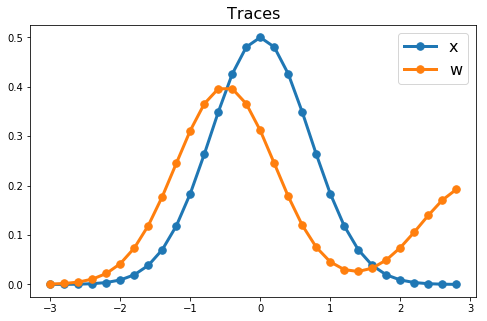

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(t, x_np[0,:,0], ".-", linewidth=3, markersize=15, label="x")
plt.plot(t, w_np[0,:,0], ".-", linewidth=3, markersize=15, label="w")
plt.legend(fontsize=16)
plt.title("Traces", fontsize=16)

(◻ [0, inf]( x <= 1.0 )) ∧ (◻ [0, inf]( w <= 0.9 ))


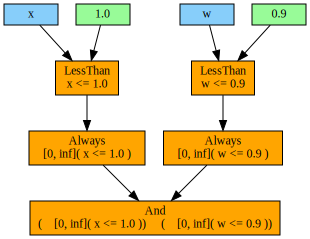

In [6]:
ϕ1 = stlcg.LessThan(name='x', val=c)
ϕ2 = stlcg.GreaterThan(name='w', val=d)
ϕ3 = stlcg.LessThan(name='w', val=d)
ϕ = stlcg.Always(subformula=ϕ1)
ψ = stlcg.Always(subformula=ϕ3)
formula = stlcg.And(subformula1=ϕ, subformula2=ψ)
print(formula)
viz.make_stl_graph(formula)

In [12]:
ψ = stlcg.Then(subformula1=ϕ1, subformula2=ϕ2)

In [13]:
pscale = 1
scale = -1
keepdim = True

# Signal convolutional logic

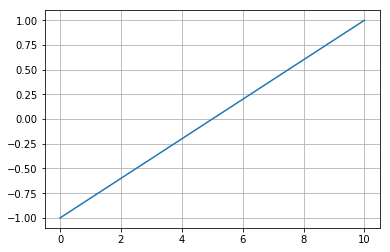

In [59]:
plt.plot(np.arange(-1., 1.2, 0.2))
plt.grid()

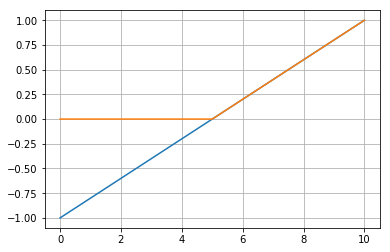

In [122]:
dt = 1.0
y_ = np.arange(-1.0, 1.2, 0.2)
y = torch.tensor(y_).unsqueeze(0).unsqueeze(-1).float()
weight = torch.ones(y.shape) * dt
plt.plot(y.squeeze().numpy())
plt.plot(torch.relu(y).squeeze().numpy())

plt.grid()

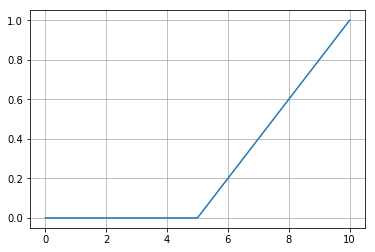

In [137]:
yy = torch.relu(y).squeeze().numpy()
weight = np.ones(y_.shape) * 2
weight[0] -= 1
weight[-1] -= 1
weight /= 2.0
yconv = np.convolve(yy, weight, mode="valid")
plt.plot(yy)
# plt.plot(yconv)
plt.grid()

In [139]:
yconv

array([2.50000004])

In [186]:
dt = 1.0
signal = x
mask = torch.ones(signal.shape)
mask *= 2
mask[:,0,:] -= 1
mask[:,-1,:] -= 1
mask *= dt/2
torch.nn.functional.conv1d(signal, mask)

tensor([[[4.4309]]])

In [184]:
dt = 1.0
mask = torch.ones(signal.shape)
torch.nn.functional.conv1d(signal, mask)

tensor([[[1772.4097]]])

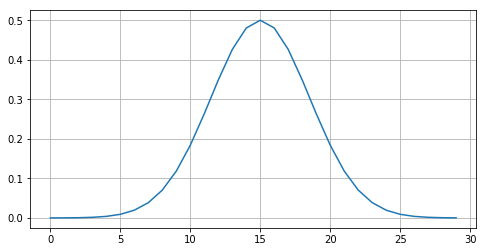

In [189]:
plt.figure(figsize=(8,4))
plt.plot(signal.squeeze().numpy())
plt.grid()

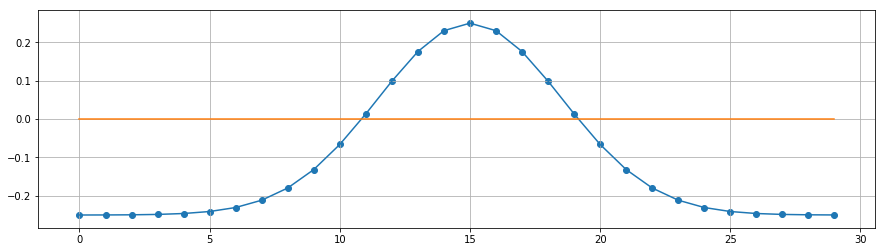

In [212]:
signal = x - 0.25
bsignal = 1.0*(signal > 0)
mask = torch.ones(signal.shape)
mask *= 2
mask[:,0,:] -= 1
mask[:,-1,:] -= 1
mask *= dt/2
p = 5
plt.plot(range(len(signal.squeeze())), signal.squeeze().numpy())
plt.scatter(range(len(signal.squeeze())), signal.squeeze().numpy())

plt.plot([0, len(signal.squeeze())-1], [0, 0])
plt.grid()

In [227]:
with torch.no_grad():
    print(q.grad)

tensor([-1.])


In [77]:

class Integral1d(stlcg.STL_Formula):
    def __init__(self, subformula, interval=None, signal_length_max=200):
        super(Integral1d, self).__init__()
        self.subformula = subformula
        padding_size = signal_length_max - 1 if interval is None else interval[1]
        self.padding = -torch.ones([1, padding_size, 1])*100.0
        kernel = signal_length_max if interval is None else interval[1] - interval[0] + 1
        
        
        self.conv = torch.nn.Conv1d(1, 1, kernel, padding=0, bias=False)
        for param in self.conv.parameters():
            param.requires_grad = False
        self.conv.weight /= self.conv.weight
#         self.conv.weight[:,:,0] /= 2
#         self.conv.weight[:,:,-1] /= 2
#         self.conv.weight


    def robustness_trace(self, inputs, pscale=1, scale=-1, keepdim=False, use_relu=False, **kwargs):
        signal = torch.cat([self.padding.to("cpu"), self.subformula(inputs, pscale=pscale, scale=scale, keepdim=keepdim, **kwargs)], dim=1).transpose(1,2)
        if use_relu:
            return self.conv(torch.relu(signal)).transpose(1,2)[:,:signal.shape[2],:]
        else:
            return self.conv(signal).transpose(1,2)[:,:signal.shape[2],:]
#         return torch.nn.functional.conv1d(torch.relu(self.subformula(inputs, pscale=pscale, scale=scale, keepdim=keepdim, **kwargs)), self.mask)

    def _next_function(self):
        # next function is actually input (traverses the graph backwards)
        return [self.subformula]

    def __str__(self):
        return "I(" + str(self.subformula) + ")"



In [78]:
ϕa = Integral1d(subformula=stlcg.Identity())
ϕb = Integral1d(subformula=stlcg.Identity(), interval=[0, 5])
ϕc = Integral1d(subformula=stlcg.Identity(), interval=[2, 5])
ϕd = stlcg.Always(subformula=stlcg.Identity(), interval=[0, 5])
ϕe = stlcg.Always(subformula=stlcg.Identity(), interval=[2, 5])

In [79]:
dt = 1.0
signal = x - 0.25
bsignal = 1.0*(signal > 0)
mask = torch.ones(signal.shape)
mask *= 2
mask[:,0,:] -= 1
mask[:,-1,:] -= 1
mask *= dt/2
p = 5
plt.figure(figsize=(15,6))

plt.plot(range(len(signal.squeeze())), signal.squeeze().numpy())
plt.scatter(range(len(signal.squeeze())), signal.squeeze().numpy())

plt.plot(range(len(signal.squeeze())), ϕa(signal).squeeze().numpy(), label="a")
plt.plot(range(len(signal.squeeze())), ϕb(signal).squeeze().numpy(), label="b")
plt.plot(range(len(signal.squeeze())), ϕc(signal).squeeze().numpy(), label="c")
plt.plot(range(len(signal.squeeze())), ϕd(signal).squeeze().numpy(), label="d")
# plt.plot(range(len(signal.squeeze())), ϕe(signal).squeeze().numpy())

plt.plot([0, len(signal.squeeze())-1], [0, 0], "--")
plt.legend()
plt.grid()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

<Figure size 1080x432 with 0 Axes>

In [80]:
obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()     # red box in bottom right corner
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression(obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression(obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression(obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression(u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

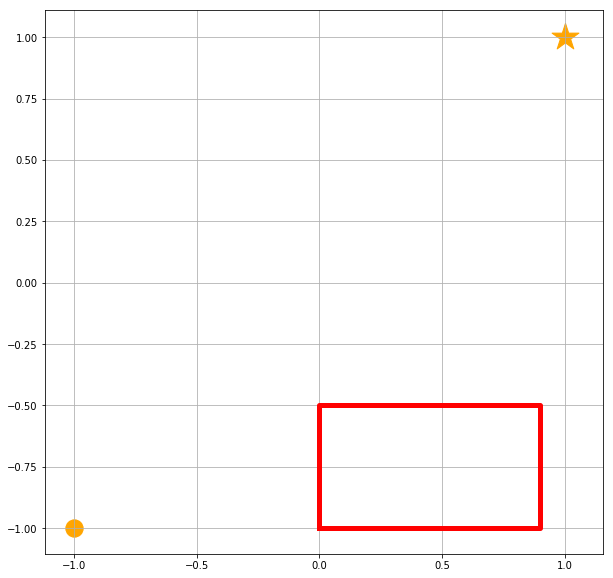

In [81]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter([-1], [-1], s=300, c="orange")
plt.scatter([1], [1], s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()


In [82]:
dx = 0.04
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = -np.ones(2)
xf = np.ones(2)
N = n.shape

u_max = torch.as_tensor(0.8).float()       # u max


In [103]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


In [121]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

In [172]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 5
inside_box_1, _ = inside_box(X, obs_1)
ϕ1 = stlcg.Eventually(subformula=Integral1d(subformula=inside_box_1, interval=[0,T], padding_type="zero", custom_number=0.1))

θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ1.robustness(box_inputs, scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

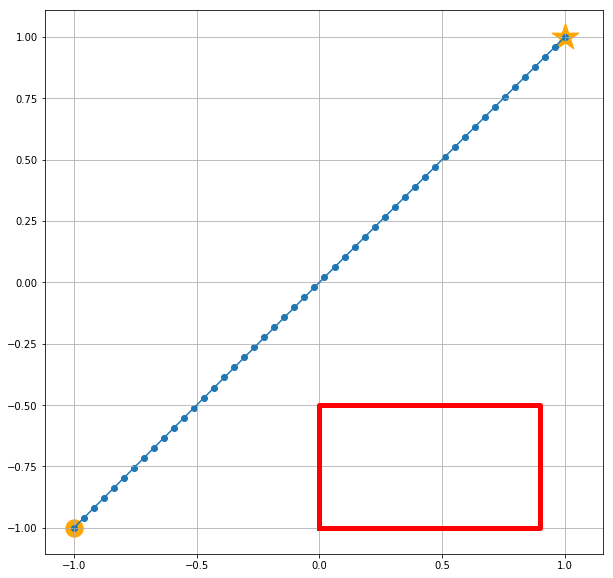

In [173]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter([-1], [-1], s=300, c="orange")
plt.scatter([1], [1], s=800, marker='*', c="orange")
plt.plot(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.scatter(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.axis("equal")
plt.grid()


(-10, 1)

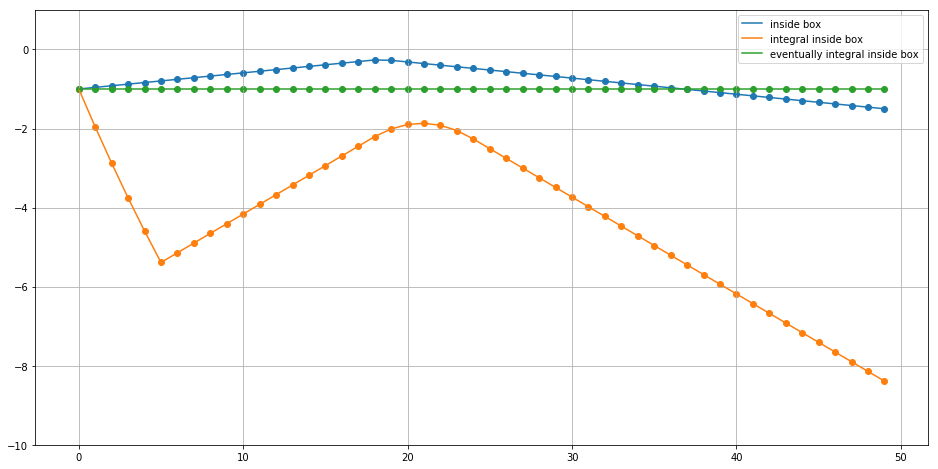

In [174]:
plt.figure(figsize=(16, 8))
signal = inside_box_1(box_inputs).detach().squeeze().numpy()
plt.plot(range(len(signal)), signal, label="inside box")
plt.scatter(range(len(signal)), signal)

integral = ϕ1.subformula(box_inputs).detach().squeeze().numpy()
plt.plot(range(len(signal)), integral, label="integral inside box")
plt.scatter(range(len(signal)), integral)

rob = ϕ1(box_inputs).detach().squeeze().numpy()
plt.plot(range(len(signal)), rob, label="eventually integral inside box")
plt.scatter(range(len(signal)), rob)

plt.legend()
plt.grid()
plt.ylim([-10, 1])


Conv1d(1, 1, kernel_size=(6,), stride=(1,), bias=False)

In [171]:
class Integral1d(stlcg.STL_Formula):
    def __init__(self, subformula, interval=None, signal_length_max=200, integration_scheme="riemann", padding_type="same", custom_number=100):
        super(Integral1d, self).__init__()
        self.subformula = subformula
        padding_size = signal_length_max - 1 if interval is None else interval[1]
        kernel = signal_length_max if interval is None else (interval[1] - interval[0] + 1)
        self.interval = interval
        self.padding_type = padding_type
        if padding_type == "zero":
            self.padding = torch.zeros([1, padding_size, 1])
        elif padding_type == "custom":
            self.padding = torch.ones([1, padding_size, 1])*custom_number
        elif padding_type == "same":
            self.padding = torch.ones([1, padding_size, 1])
        
        self.conv = torch.nn.Conv1d(1, 1, kernel, padding=0, bias=False)
        for param in self.conv.parameters():
            param.requires_grad = False
        self.conv.weight /= self.conv.weight
        
        if integration_scheme == "trapz":
            self.conv.weight[:,:,0] /= 2
            self.conv.weight[:,:,-1] /= 2


    def robustness_trace(self, inputs, pscale=1, scale=-1, keepdim=False, use_relu=False, **kwargs):
        padding = self.padding
        if self.padding_type == "same":
            padding = self.padding * self.subformula(inputs, pscale=pscale, scale=scale, keepdim=keepdim, **kwargs)[:,0,:]
        signal = torch.cat([padding.to("cpu"), self.subformula(inputs, pscale=pscale, scale=scale, keepdim=keepdim, **kwargs)], dim=1).transpose(1,2)
        if use_relu:
            return self.conv(torch.relu(signal)).transpose(1,2)[:,:signal.shape[2],:]
        else:
            return self.conv(signal).transpose(1,2)[:,:signal.shape[2],:]

    def _next_function(self):
        # next function is actually input (traverses the graph backwards)
        return [self.subformula]

    def __str__(self):
        return "I" + str(self.interval) + "(" + str(self.subformula) + ")"

